In [1]:
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from os import listdir
import matplotlib.pyplot as plt
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from sklearn.model_selection import train_test_split

In [2]:
Input_img = Input(shape=(256, 324, 1))  
    
#encoding architecture
x1 = Conv2D(256, (3, 3), activation='relu', padding='same')(Input_img)
x2 = Conv2D(128, (3, 3), activation='relu', padding='same')(x1)
x2 = MaxPool2D( (2, 2))(x2)
encoded = Conv2D(64, (3, 3), activation='relu', padding='same')(x2)

# decoding architecture
x3 = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x3 = UpSampling2D((2, 2))(x3)
x2 = Conv2D(128, (3, 3), activation='relu', padding='same')(x3)
x1 = Conv2D(256, (3, 3), activation='relu', padding='same')(x2)
decoded = Conv2D(1, (3, 3), padding='same')(x1)

autoencoder = Model(Input_img, decoded)
autoencoder.compile(optimizer = 'adam', loss = 'huber', metrics = 'mae')

2022-12-27 06:30:57.177643: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-27 06:30:57.297020: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-27 06:30:57.298038: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-27 06:30:57.300122: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [3]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 324, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 324, 256)     2560      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 324, 128)     295040    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 162, 128)     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 162, 64)      73792     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 162, 64)      36928     
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 256, 324, 64)      0     

In [4]:
def preprocess_image(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = np.asarray(img, dtype = 'float32')
    img = cv2.resize(img, (324, 256))
    img = img/255.0
    
    return img

In [5]:
train_path = r'../input/denoise/denoising-dirty-documents/train/train/'
train_cleaned_path = r'../input/denoise/denoising-dirty-documents/train_cleaned/train_cleaned/'
test_path = r'../input/denoise/denoising-dirty-documents/test/test/'

train = []
train_cleaned = []
test = []

for files in tqdm(listdir(train_path)):
    img_path = train_path + files
    train.append(preprocess_image(img_path))
    
for files in tqdm(listdir(train_cleaned_path)):
    img_path = train_cleaned_path + files
    train_cleaned.append(preprocess_image(img_path))
    
for files in tqdm(listdir(test_path)):
    img_path = test_path + files
    test.append(preprocess_image(img_path))

100%|██████████| 72/72 [00:00<00:00, 119.59it/s]


In [6]:
train_arr = np.array(train)
train_cleaned_arr = np.array(train_cleaned)
test_arr = np.array(test)

In [7]:
train_arr.shape

(144, 256, 324)

(-0.5, 323.5, 255.5, -0.5)

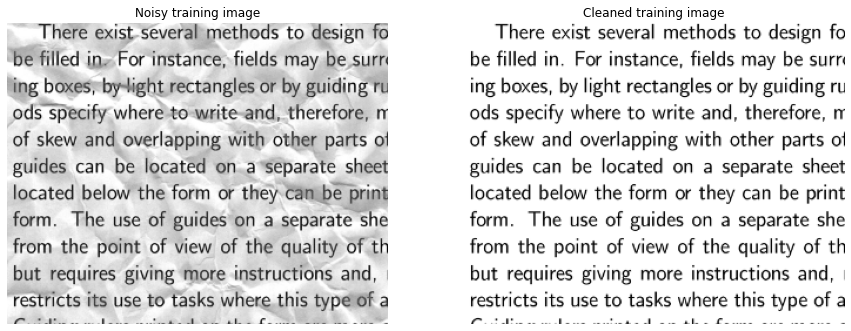

In [8]:
fig = plt.figure(figsize = (15, 25))

fig.add_subplot(1, 2, 1)
plt.imshow(train_arr[20], cmap = 'gray')
plt.title('Noisy training image')
plt.axis('off')

fig.add_subplot(1, 2, 2)
plt.imshow(train_cleaned_arr[20], cmap = 'gray')
plt.title('Cleaned training image')
plt.axis('off')

In [9]:
X_train, X_valid, y_train, y_valid = train_test_split(train_arr, train_cleaned_arr, test_size = 0.2, random_state = 1)

In [10]:
history = autoencoder.fit(X_train, y_train,
                          epochs = 600,
                          batch_size = 16,
                          validation_data = (X_valid, y_valid))

2022-12-27 06:31:03.009677: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/600


2022-12-27 06:31:04.361407: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


8/8 [==============================] - 21s 1s/step - loss: 0.2884 - mae: 0.6969 - val_loss: 0.1298 - val_mae: 0.4876
Epoch 2/600
8/8 [==============================] - 5s 605ms/step - loss: 0.0702 - mae: 0.3151 - val_loss: 0.0527 - val_mae: 0.3059
Epoch 3/600
8/8 [==============================] - 5s 604ms/step - loss: 0.0376 - mae: 0.1979 - val_loss: 0.0314 - val_mae: 0.2070
Epoch 4/600
8/8 [==============================] - 5s 603ms/step - loss: 0.0300 - mae: 0.1679 - val_loss: 0.0269 - val_mae: 0.1553
Epoch 5/600
8/8 [==============================] - 5s 604ms/step - loss: 0.0269 - mae: 0.1490 - val_loss: 0.0246 - val_mae: 0.1551
Epoch 6/600
8/8 [==============================] - 5s 605ms/step - loss: 0.0241 - mae: 0.1452 - val_loss: 0.0219 - val_mae: 0.1432
Epoch 7/600
8/8 [==============================] - 5s 604ms/step - loss: 0.0220 - mae: 0.1428 - val_loss: 0.0205 - val_mae: 0.1330
Epoch 8/600
8/8 [==============================] - 5s 604ms/step - loss: 0.0216 - mae: 0.1458 - v

In [11]:
history_df = pd.DataFrame(history.history)

<AxesSubplot:>

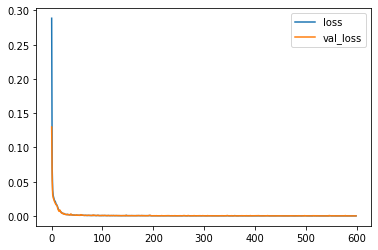

In [12]:
history_df.loc[ : , ['loss', 'val_loss']].plot()

<AxesSubplot:>

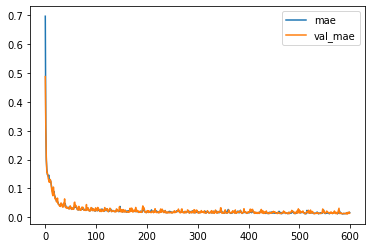

In [13]:
history_df.loc[ : , ['mae', 'val_mae']].plot()

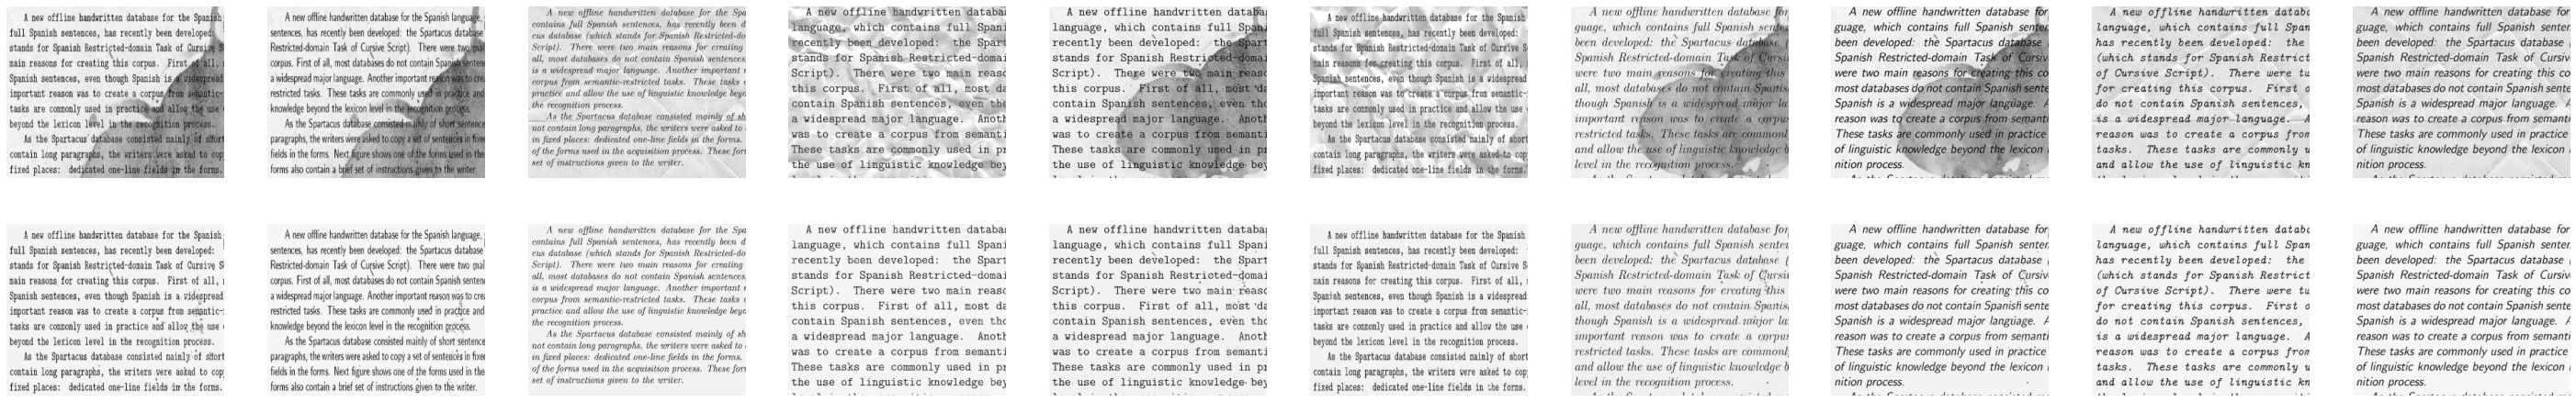

In [14]:
decoded_imgs = autoencoder.predict(test_arr)

n = 10
row = 2
column = 10

fig = plt.figure(figsize = (5 * column, 4 * row))
for i in range(1, n + 1):
    fig.add_subplot(2, n, i)
    plt.imshow(test_arr[i], cmap = 'gray')
    plt.axis('off')

    fig.add_subplot(2, n, n + i)
    plt.imshow(decoded_imgs[i], cmap = 'gray')
    plt.axis('off')

In [15]:
autoencoder.save(r'./AutoEncoder_Document_Denoise.h5')

(-0.5, 323.5, 255.5, -0.5)

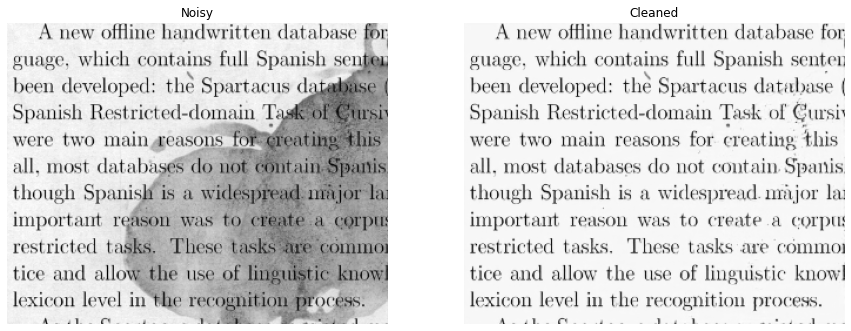

In [16]:
fig = plt.figure(figsize = (15, 25))

fig.add_subplot(1, 2, 1)
plt.imshow(test_arr[20], cmap = 'gray')
plt.title('Noisy')
plt.axis('off')

fig.add_subplot(1, 2, 2)
plt.imshow(decoded_imgs[20], cmap = 'gray')
plt.title('Cleaned')
plt.axis('off')